In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
# from __future__ import print_function, division
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import time
from torch.utils.data import DataLoader
import gc
import cv2

import sys
sys.path.append('./Fast-ACVNet-main/')

from models import __models__, model_loss_train, model_loss_test

In [5]:
parser = argparse.ArgumentParser(description='Accurate and Efficient Stereo Matching via Attention Concatenation Volume (Fast-ACV)')
parser.add_argument('--model', default='Fast_ACVNet_plus', help='select a model structure', choices=__models__.keys())
parser.add_argument('--maxdisp', type=int, default=192, help='maximum disparity')
parser.add_argument('--attention_weights_only', default=False, type=str,  help='only train attention weights')

_StoreAction(option_strings=['--attention_weights_only'], dest='attention_weights_only', nargs=None, const=None, default=False, type=<class 'str'>, choices=None, required=False, help='only train attention weights', metavar=None)

In [6]:
args, unknown = parser.parse_known_args()

In [7]:
model = __models__[args.model](args.maxdisp, args.attention_weights_only)
model = nn.DataParallel(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [10]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------
# Metric Function
# ---------------------------
def evaluate_vs_gt(disp_pred, disp_gt):
    mask = disp_gt > 0  # KITTI valid region

    diff = np.abs(disp_pred - disp_gt)

    mae  = np.mean(diff[mask])
    rmse = np.sqrt(np.mean((diff[mask])**2))
    bad1 = np.mean(diff[mask] > 1.0) * 100
    bad3 = np.mean(diff[mask] > 3.0) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Bad1%": bad1,
        "Bad3%": bad3
    }

# ---------------------------
# Load RGB image as (C,H,W) float32
# ---------------------------
def load_rgb(path):
    img = np.asarray(Image.open(path).convert("RGB"), dtype=np.float32) / 255.0
    img = torch.from_numpy(img).permute(2,0,1).float()  # (3,H,W)
    return img

# ---------------------------
# Load KITTI disparity (uint16/256)
# ---------------------------
def load_disp_kitti(path):
    disp_raw = np.asarray(Image.open(path), dtype=np.uint16)
    disp = disp_raw.astype(np.float32) / 256.0
    return disp

def pad_to_48(img):

    B, C, H, W = img.shape
    pad_h = (48 - (H % 48)) % 48
    pad_w = (48 - (W % 48)) % 48

    img = F.pad(img, (0, pad_w, 0, pad_h))  # pad right and bottom
    return img, pad_h, pad_w

# ---------------------------
# Full Evaluation Function
# ---------------------------
def run_full_evaluation(
    model,                # already-constructed model class
    checkpoint_path,      # .ckpt or .pth (state_dict)
    left_path,
    right_path,
    gt_disp_path,
    focal_length=721.5,
    baseline=0.54
):
    # ---------------------------
    # Load trained weights
    # ---------------------------
    print("Loading checkpoint...")
    state = torch.load(checkpoint_path, map_location="cuda")
    model.load_state_dict(state["model"])

    model.eval()
    model.cuda()

    # ---------------------------
    # Load images (RGB)
    # ---------------------------
    left  = load_rgb(left_path).unsqueeze(0)
    right = load_rgb(right_path).unsqueeze(0)

    left, pad_h, pad_w = pad_to_48(left)
    right, _, _ = pad_to_48(right)

    print(left.shape, right.shape)

    # # Input expected by your training: (6,H,W)
    # inp = torch.cat([left, right], dim=0).unsqueeze(0)  # (1,6,H,W)

    # # Model expects (B,H,W,C)
    # inp_for_model = inp.permute(0, 2, 3, 1)

    # ---------------------------
    # Run inference
    # ---------------------------
    with torch.no_grad():
        pred = model(left, right)[0]

    print(f"pred:{type(pred)}")

    # Model outputs (B,H,W,1) → convert to (H,W)
    pred_disp = pred.squeeze().cpu().numpy()

    # ---------------------------
    # Load GT disparity
    # ---------------------------
    gt_disp = gt_disp = torch.from_numpy(load_disp_kitti(gt_disp_path)).float()
    gt_disp = gt_disp.unsqueeze(0).unsqueeze(0)

    gt_disp, _, _ = pad_to_48(gt_disp)
    gt_disp = gt_disp.squeeze(0).squeeze(0).cpu().numpy()   # H×W

    # gt_disp = gt_disp.squeeze()

    # ---------------------------
    # Compute metrics
    # ---------------------------
    metrics = evaluate_vs_gt(pred_disp, gt_disp)
    print("\n📌 Evaluation Metrics")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")

    # ---------------------------
    # Compute depth maps
    # ---------------------------
    depth_pred = (focal_length * baseline) / np.maximum(pred_disp, 1e-6)
    depth_gt   = (focal_length * baseline) / np.maximum(gt_disp, 1e-6)

    # ---------------------------
    # Plot all results
    # ---------------------------
    plt.figure(figsize=(12,4.8))

    plt.subplot(2,3,1)
    plt.title("Predicted Disparity")
    plt.imshow(pred_disp, cmap='plasma')
    plt.colorbar()

    plt.subplot(2,3,2)
    plt.title("GT Disparity")
    plt.imshow(gt_disp, cmap='plasma')
    plt.colorbar()

    plt.subplot(2,3,3)
    plt.title("Error Map |disp_pred - disp_gt|")
    plt.imshow(np.abs(pred_disp - gt_disp), cmap='inferno')
    plt.colorbar()

    plt.subplot(2,3,4)
    plt.title("Predicted Depth (m)")
    plt.imshow(depth_pred, cmap='viridis')
    plt.colorbar()

    plt.subplot(2,3,5)
    plt.title("Ground Truth Depth (m)")
    plt.imshow(depth_gt, cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return pred_disp, metrics


Loading checkpoint...
torch.Size([1, 3, 384, 1248]) torch.Size([1, 3, 384, 1248])
pred:<class 'torch.Tensor'>

📌 Evaluation Metrics
MAE: 0.9122
RMSE: 1.5680
Bad1%: 28.0796
Bad3%: 4.5022


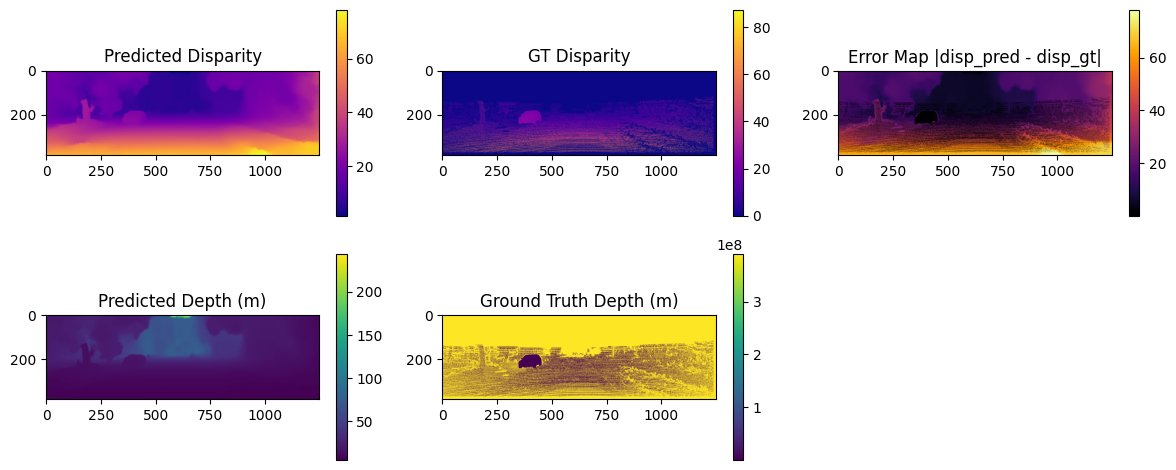

(array([[18.636488, 18.637934, 18.640175, ..., 35.045544, 34.90977 ,
         34.963455],
        [18.639414, 18.637474, 18.637825, ..., 35.24576 , 34.959892,
         35.051243],
        [18.63505 , 18.638603, 18.637283, ..., 35.569584, 35.448032,
         35.537163],
        ...,
        [63.00507 , 63.038364, 63.017128, ..., 70.85791 , 70.81014 ,
         70.72258 ],
        [63.011242, 63.10156 , 63.090595, ..., 70.915695, 70.980675,
         70.87762 ],
        [63.007145, 63.09654 , 63.07832 , ..., 70.919716, 70.9999  ,
         70.98166 ]], dtype=float32),
 {'MAE': np.float32(0.91219866),
  'RMSE': np.float32(1.5679858),
  'Bad1%': np.float64(28.079587124813255),
  'Bad3%': np.float64(4.502240934401739)})

In [11]:
run_full_evaluation(
    model=model,
    checkpoint_path="Fast-ACVNet-main/checkpoint_000498.ckpt",
    left_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png",
    right_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png",
    gt_disp_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"
)
